In [1]:
#! pip install grad-cam timm

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from skimage import color
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
#from torch.utils.tensorboard import SummaryWriter

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad

%matplotlib inline

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [50]:
valid_img_path_1 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/1.training/1.training/436219-7159-48057-[1, 0, 0].png'
#valid_img_path_1 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/1.training/1.training/1222870-17531-5689-[0, 0, 1].png'
#valid_img_path_2 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/1.training/1.training/436219-22342-50847-[1, 1, 0].png'
valid_img_path_2 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/1.training/1.training/436219-9328-56427-[1, 1, 0].png'#436219-9328-53637-[1, 1, 0].png
valid_img_path_3 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/1.training/1.training/1003370-5631-18822-[0, 1, 0].png'
valid_img_path_4 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/1.training/1.training/449636-23526-9666-[0, 0, 1].png'
valid_img_path_5 = '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/2.validation/2.validation/img/06.png'

In [51]:
valid_img_1 = cv2.resize(cv2.imread(valid_img_path_1), (224, 224))
valid_img_2 = cv2.resize(cv2.imread(valid_img_path_2), (224, 224))
valid_img_3 = cv2.resize(cv2.imread(valid_img_path_3), (224, 224))
valid_img_4 = cv2.resize(cv2.imread(valid_img_path_4), (224, 224))
valid_img_5 = cv2.resize(cv2.imread(valid_img_path_5), (224, 224))

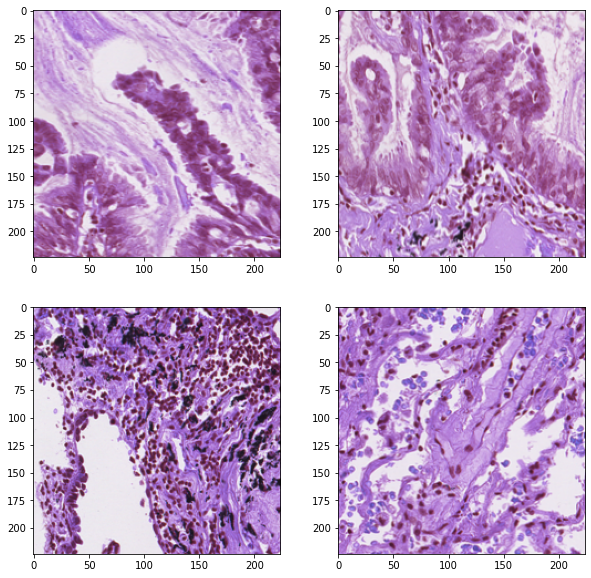

In [52]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(valid_img_1)

ax = fig.add_subplot(2, 2, 2)
plt.imshow(valid_img_2)

ax = fig.add_subplot(2, 2, 3)
plt.imshow(valid_img_3)

ax = fig.add_subplot(2, 2, 4)
plt.imshow(valid_img_4)

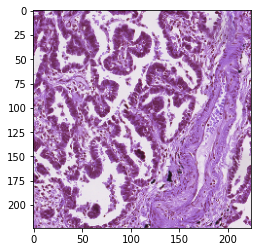

In [53]:
plt.imshow(valid_img_5)

In [6]:
def preprocess_image(img: np.ndarray, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(mean, std),
                                      ])
  return preprocessing(img.copy()).unsqueeze(0)


In [7]:
def reshape_transform(tensor, height=7, width=7):
  result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                                       height, width, tensor.size(2))
  
  # Bring the channels to the first dimension,
  # like in CNNs.
  result = result.transpose(2, 3).transpose(1, 2)
  return result

In [8]:
def mask_threshold(mask):
    v = np.concatenate(mask)
    t = v.mean()
    d = np.inf
    ds = 0.005
    while d > ds:
        g1 = v[v>t]
        g2 = v[v<=t]
        m1 = g1.mean()
        m2 = g2.mean()
        tp = (m1 + m2)/2
        d = np.abs(t - tp)
        t = tp
        #print(t)

    imt = mask > t

    return imt

In [9]:
model_weights = ['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/' + x for
                 x in os.listdir('/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models') if
                 '32' in x and 'deit' not in x]
model_weights.sort()
model_weights

['/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/bor_ref_tum-str_vit_base_patch32_224_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/bor_ref_tum-str_vit_base_patch32_224_02.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/bor_ref_tum-str_vit_base_patch32_224_03.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/cutmix_model_vit_base_patch32_224_01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/cutmix_model_vit_base_patch32_224_02.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch32_224_1-01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch32_224_1-02.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch32_224_1.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch32_224_2-01.pth',
 '/home/zephyr/Desktop/Newcastle_University/11_FP_D/Models/model_vit_base_patch32_224_2.pth',
 '

# Model 0: model_vit_32_224.pth

In [10]:
model_vit_base_patch16_224 = timm.create_model('vit_base_patch32_224', pretrained = False, num_classes = 3,
                                               drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

In [54]:
model_vit_base_patch16_224.load_state_dict(torch.load(f=model_weights[2], map_location=device))

<All keys matched successfully>

In [55]:
%%capture
model_vit_base_patch16_224.eval()

In [56]:
target_layer = [model_vit_base_patch16_224.blocks[-1].norm1]
target_layer

[LayerNorm((768,), eps=1e-06, elementwise_affine=True)]

In [57]:
mean = [0.697, 0.535, 0.768]
std = [0.134, 0.192, 0.149]

In [58]:
valid_img_1_tensor = preprocess_image(valid_img_1, mean=mean, std=std).to(device)
valid_img_2_tensor = preprocess_image(valid_img_2, mean=mean, std=std).to(device)
valid_img_3_tensor = preprocess_image(valid_img_3, mean=mean, std=std).to(device)
valid_img_4_tensor = preprocess_image(valid_img_4, mean=mean, std=std).to(device)
valid_img_5_tensor = preprocess_image(valid_img_5, mean=mean, std=std).to(device)

In [37]:
valid_img_1_tensor = preprocess_image(valid_img_1,).to(device)
valid_img_2_tensor = preprocess_image(valid_img_2,).to(device)
valid_img_3_tensor = preprocess_image(valid_img_3,).to(device)
valid_img_4_tensor = preprocess_image(valid_img_4,).to(device)
valid_img_5_tensor = preprocess_image(valid_img_5,).to(device)

In [26]:
img_t = cv2.resize(cv2.imread('/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/WSSS4LUAD/2.validation/2.validation/img/06.png'), (224, 224))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


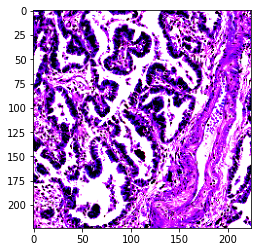

In [27]:
plt.imshow(preprocess_image(img_t).squeeze(0).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


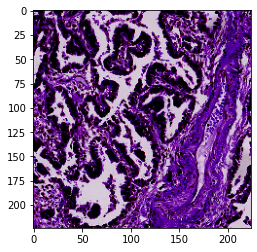

In [28]:
plt.imshow(preprocess_image(img_t, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]).squeeze(0).permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


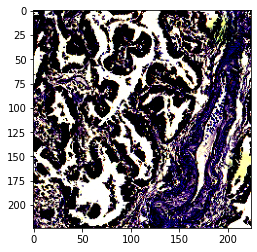

In [29]:
plt.imshow(preprocess_image(img_t, mean=mean, std=std).squeeze(0).permute(1, 2, 0))

## 01. GradCAM: img 0

In [59]:
cam = GradCAM(model = model_vit_base_patch16_224, target_layers=target_layer,
              reshape_transform=reshape_transform)

### Class 0: Tumor

In [93]:
valid_cam_0 = cam(input_tensor=valid_img_2_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=valid_img_2_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=valid_img_2_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

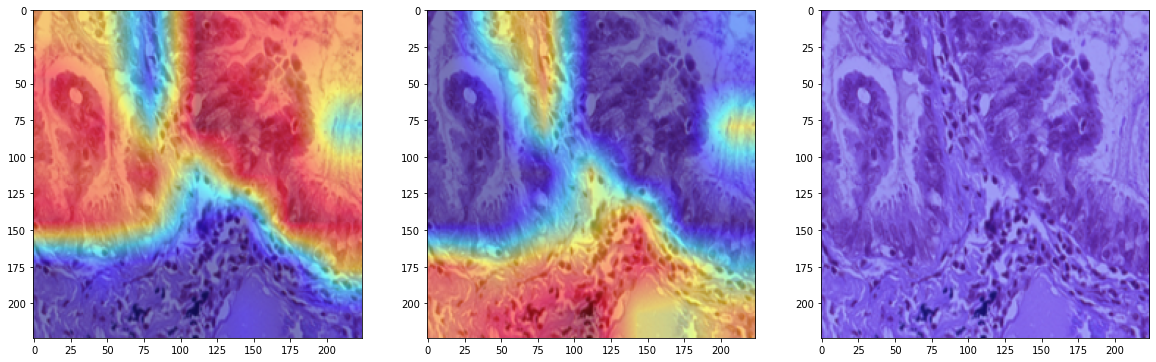

In [94]:
fig = plt.figure(figsize=(20, 40))
'''
ax = fig.add_subplot(1, 4, 1)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 2)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 3)
plt.imshow(valid_img)

ax = fig.add_subplot(1, 4, 4)
plt.imshow(valid_img)
'''
ax = fig.add_subplot(1, 3, 1)
plt.imshow(show_cam_on_image(valid_img_2/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(show_cam_on_image(valid_img_2/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 3)
plt.imshow(show_cam_on_image(valid_img_2/255, valid_cam_2[0, :], use_rgb=True))

In [40]:
#x = preprocess_image(img_t, mean=mean, std=std)
x = preprocess_image(img_t,)

valid_cam_0 = cam(input_tensor=x, targets=[ClassifierOutputTarget(np.array([0]))])
valid_cam_1 = cam(input_tensor=x, targets=[ClassifierOutputTarget(np.array([1]))])
valid_cam_2 = cam(input_tensor=x, targets=[ClassifierOutputTarget(np.array([2]))])

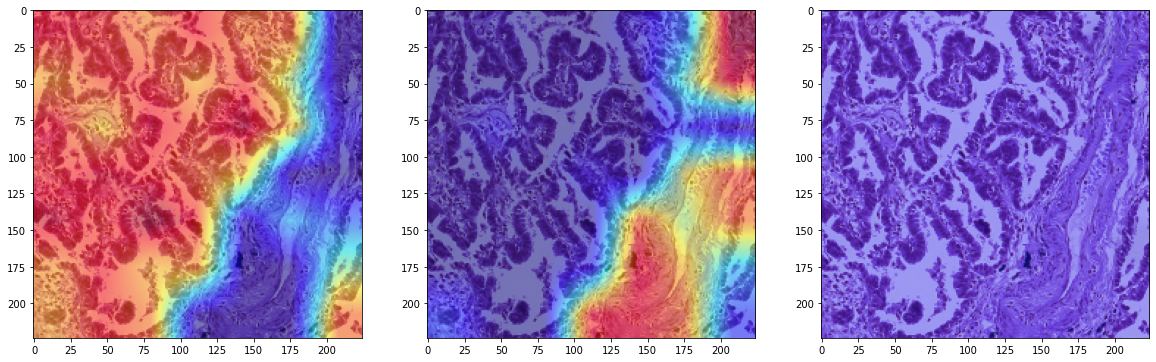

In [41]:
fig = plt.figure(figsize=(20, 40))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(show_cam_on_image(img_t/255, valid_cam_0[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 2)
plt.imshow(show_cam_on_image(img_t/255, valid_cam_1[0, :], use_rgb=True))

ax = fig.add_subplot(1, 3, 3)
plt.imshow(show_cam_on_image(img_t/255, valid_cam_2[0, :], use_rgb=True))

In [62]:
import PAR

In [63]:
par = PAR.PAR(num_iter=15, dilations=[1,2,4,8,16,32])

In [64]:
par.to(device)

PAR()

In [114]:
mask = par(valid_img_2_tensor, transforms.ToTensor()(valid_cam_1[0, :]).unsqueeze(0))

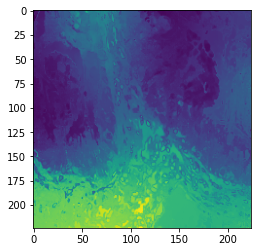

In [115]:
plt.imshow(mask.squeeze(0).squeeze(0))

In [116]:
from sklearn.preprocessing import minmax_scale

In [117]:
t = mask.squeeze(0).squeeze(0).cpu().detach().numpy()
t.shape

(224, 224)

In [118]:
t.reshape(-1, 1).shape

(50176, 1)

In [119]:
t.shape

(224, 224)

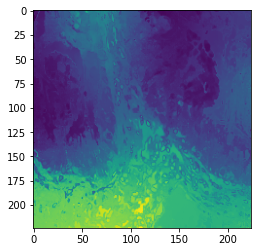

In [120]:
test = minmax_scale(t.reshape(-1, 1))
test = test.reshape(224, 224)
plt.imshow(test)

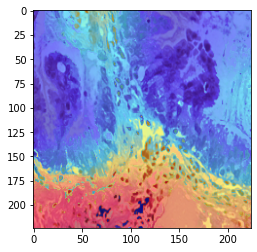

In [152]:
plt.imshow(show_cam_on_image(valid_img_2/255, mask.cpu().detach().numpy().squeeze(0).squeeze(0), use_rgb=True))

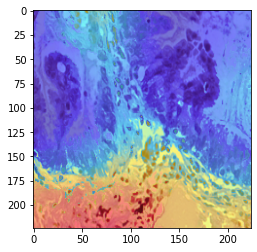

In [151]:
plt.imshow(show_cam_on_image(valid_img_2/255, test, use_rgb=True))

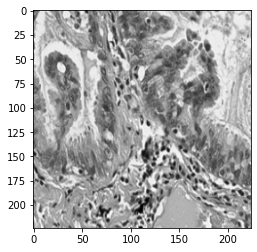

In [123]:
gray = cv2.cvtColor(valid_img_2, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

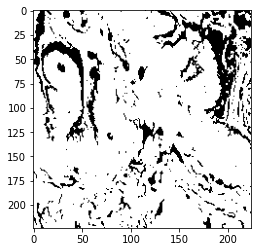

In [124]:
ret, thresh = cv2.threshold(gray, 210, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh, cmap='gray')

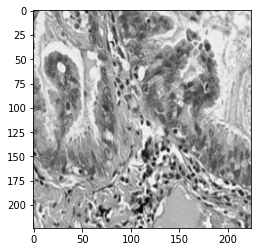

In [135]:
gray = cv2.cvtColor(valid_img_2_tensor.squeeze(0).permute(1, 2, 0).numpy(), cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

In [145]:
np.percentile(gray, 75)

0.7784664630889893

In [141]:
np.max(gray)

2.0347283

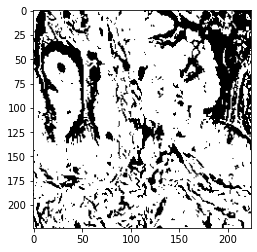

In [146]:
ret, thresh = cv2.threshold(gray, 0.7, 2.03, cv2.THRESH_BINARY_INV)
plt.imshow(thresh, cmap='gray')

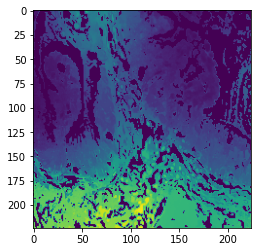

In [147]:
mask_bg_rem = mask.squeeze(0).squeeze(0)*thresh
plt.imshow(mask_bg_rem)

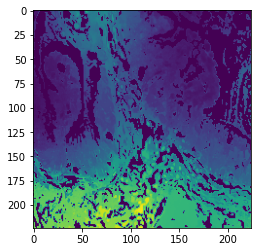

In [148]:
mask_bg_rem_2 = test.reshape(224, 224)*thresh
plt.imshow(mask_bg_rem)

In [127]:
type(mask_bg_rem)

torch.Tensor

In [128]:
type(mask_bg_rem_2)

numpy.ndarray

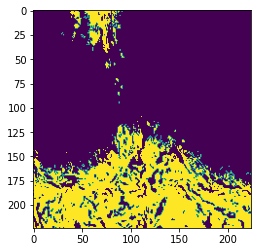

In [149]:
plt.imshow(mask_threshold(mask_bg_rem.cpu().detach().numpy()))

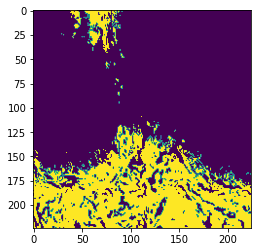

In [150]:
plt.imshow(mask_threshold(mask_bg_rem_2))

In [161]:
np.percentile(mask_bg_rem, 75)
np.unique(mask_bg_rem_2)

array([0.0000000e+00, 1.5911635e-04, 3.5070631e-04, ..., 2.0289097e+00,
       2.0289240e+00, 2.0300000e+00], dtype=float32)

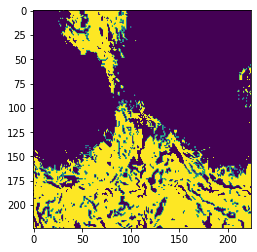

In [167]:
plt.imshow(cv2.threshold(mask_bg_rem_2,
                         0.6, 2.27, cv2.THRESH_BINARY)[1])

In [ ]:
x = mask_threshold(test*thresh)

In [ ]:
y = np.random.randint(0, 2, (224, 224))
z = np.random.randint(0, 2, (224, 224))

In [ ]:
n = np.concatenate((x.reshape(224, 224, 1), y.reshape(224, 224, 1), z.reshape(224, 224, 1)), axis=-1)
n.shape

In [ ]:
plt.imshow(n[:, : ,2])

In [ ]:
plt.imshow(1-n.max(axis=-1))

In [ ]:
plt.imshow(cv2.resize(mask_threshold(test*thresh).astype(np.float32), (174, 248)))

In [ ]:
np.unique(mask_threshold(test*thresh).astype(np.float32))

In [ ]:
plt.imshow(1-mask_threshold(test*thresh).astype(np.float32))

In [ ]:
plt.imshow(show_cam_on_image(valid_img_2/255, mask_threshold(mask_bg_rem.cpu().detach().numpy()), use_rgb=True))

In [ ]:
plt.imshow(mask_threshold(mask_bg_rem))

In [ ]:
fin = mask_threshold(mask_bg_rem.cpu().detach().numpy())
np.unique(fin.astype(np.uint8))

In [ ]:
l = cv2.imread('/home/zephyr/Desktop/Newcastle_University/11_FP_D/Dataset/training_pseudo_labels/440682-19226-27206-[1, 1, 0].png', cv2.IMREAD_UNCHANGED)

In [ ]:
l.shape

In [ ]:
plt.imshow(l[:, :, 3])